# Description
In this part of the project, we created 4 ensemble methods and compared them, using statistical analysis methods in 10 different datasets.
#### Ensembles
1. Bagging Ensemble using Random Tree Classifier.  
We follow the procedure described below:
  - Random Search, in order to search fpr hyperparameters.
  - Grid Search in the area near the best parameters found from the Random Search.
  - 10 fold Cross Validation, in order to plot the accuracy vs the number of classifiers used.
  - Prediction using the best estimation for the number of classifiers, combined with the tuned parameters.
2. Random Forest Classifier.  
We follow the procedure described below:
  - Random Search.
  - Grid Search.
  - Prediction using the tuned parameters.
3. Stacking, using two Nearest Neighbors classifiers, one Decision Tree classifier and one Naive Bayes classifier. The Meta-Classifier is a Logistic Regression Classifier.  
We follow the procedure described below:
  - Random Search.
  - Grid Search.
  - Prediction using the tuned parameters of each model.

4. Boosting, using XGBoost.  
We follow the procedure described below:
  - Random Search.
  - Grid Search.
  - Prediction using the tuned parameters of each model.

#### Datasets
1. [Contraception Methods](https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data)
2. **Wine** - Using sklearn' s import.
3. **Iris** - Using sklearn' s import.
4. [Breast Cancer](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data?fbclid=IwAR2ZT56DdRbU45HMFvq6gwTdjKsS-RLSQ0B1TQM4cskmA27x-upTF0n66BI)
5. [Seeds](https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt)
6. [Glass Identification](https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data)
7. [Tic Tac Toe](https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data)
8. [Wholesale Customers](https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv)
9. **Diabetes** - Using sklearn' s import.
10. [Teaching Assistant Evaluation](https://archive.ics.uci.edu/ml/machine-learning-databases/tae/tae.data)

#### Comparison
TODO

# Globals


### Import all modules.


In [0]:
import io
import itertools
import time

import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from pandas import read_csv
from scipy.stats import randint as sp_randint
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline


### Define global functions to be used in the project.


In [0]:

def report(results, n_top=3) -> None:
    """
    Utility function to report best scores of Grid/Random Search CV.
    
    :param results: the search results.
    :param n_top: the number of top scores to show.
    """
    for i in range(1, n_top + 1):
        scores = np.flatnonzero(results['rank_test_score'] == i)
        for score in scores:
            print('Model with rank: {0}'.format(i))
            print('Mean validation score: {0:.3f} (std: {1:.3f})'.format(
                  results['mean_test_score'][score],
                  results['std_test_score'][score]))
            print('Parameters: {0}'.format(results['params'][score]))
            print('')
            
def estimators_vs_acc(classifier, x_data, y_data, estimators_array) -> None:
    """
    Plot number of estimators vs accuracy +- std.
    """
    # Arrays to store mean and std.
    bg_clf_cv_mean = []
    bg_clf_cv_std = []
    
    # For each number of estimators run a 10 fold CV and store the results.
    for n_est in estimators_array:
        bagging_clf = BaggingClassifier(base_estimator=classifier, n_estimators=n_est)
        scores = cross_val_score(bagging_clf, x_data, y_data, cv=10, 
                                 scoring='accuracy', verbose=2, n_jobs=-1)
        bg_clf_cv_mean.append(scores.mean())
        bg_clf_cv_std.append(scores.std())
    
    # Plot the accuracy+-std vs number of estimators.
    plt.figure()
    (_, caps, _) = plt.errorbar(estimators_array, bg_clf_cv_mean, yerr=bg_clf_cv_std, 
                              c='blue', fmt='-o', capsize=5)
    
    # Configure the plot.
    for cap in caps:
        cap.set_markeredgewidth(1)                                                                                                                                
    plt.ylabel('Accuracy')
    plt.xlabel('Ensemble Size')
    plt.title('Bagging Tree Ensemble')
    plt.show()
    
def plot_accuracy_stacking(label_list,clfs,x_data,y_data):
    """
    Plot accuracy +- std for each model used in the stacking model 
    and for the final classifier.
    """
    label = label_list
    clf_list = clfs
    
    grid = itertools.product([0,1],repeat=len(clf_list) -1)

    clf_cv_mean = []
    clf_cv_std = []
    for classifier, label, grd in zip(clf_list, label, grid):
        scores = cross_val_score(classifier, x_data, y_data, cv=3, scoring='accuracy')
        print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        clf_cv_mean.append(scores.mean())
        clf_cv_std.append(scores.std())
        
        classifier.fit(x_data, y_data)
        
    plt.figure()
    (_, caps, _) = plt.errorbar(range(len(clf_list)), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)                                                                                                                                
    plt.xticks(range(len(clf_list)) , label_list)        
    plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble')
    plt.show()



# Contraception Dataset



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))
# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values
# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)


## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from, 
# candidates to be created and classifier to be used.
param_dist = {'max_depth': sp_randint(4, 30),
              'max_features': sp_randint(1, 9),
              'min_samples_split': sp_randint(2, 11),
              'criterion': ['gini', 'entropy']}
candidates = 40

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds \
      for {} candidates parameter settings.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.8s


RandomizedSearchCV took 2.97 seconds       for 40 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.529 (std: 0.046)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 4, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.521 (std: 0.039)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 6, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.511 (std: 0.042)
Parameters: {'criterion': 'gini', 'max_depth': 27, 'max_features': 8, 'min_samples_split': 10}



[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': [4, 5, 6],
              'max_features': [6, 7, 8],
              'min_samples_split': [4, 5, 6, 7],
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.2s


GridSearchCV took 2.80 seconds.
Model with rank: 1
Mean validation score: 0.564 (std: 0.037)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 7, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.564 (std: 0.037)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 7, 'min_samples_split': 6}

Model with rank: 1
Mean validation score: 0.564 (std: 0.037)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 7, 'min_samples_split': 7}

Model with rank: 1
Mean validation score: 0.564 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 8, 'min_samples_split': 4}



[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    2.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

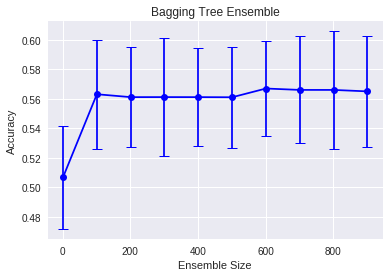

In [99]:

# Add best values for the classifier.
clf.max_depth = 4
clf.max_features = 8
clf.min_samples_split = 4
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict, using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high and the deviation is low.

In [100]:
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600)
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)
print('Final Result: \n{}'.format(classification_report(y_test,y_pred)))

Final Result: 
              precision    recall  f1-score   support

           1       0.68      0.52      0.59       180
           2       0.68      0.17      0.27       115
           3       0.44      0.84      0.58       147

   micro avg       0.53      0.53      0.53       442
   macro avg       0.60      0.51      0.48       442
weighted avg       0.60      0.53      0.50       442



## Random Forest

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from, 
# candidates to be created and classifier to be used.
param_dist = {'max_depth': sp_randint(4, 30),
              'max_features': sp_randint(1, 9),
              'min_samples_split': sp_randint(2, 11),
              'n_estimators': sp_randint(20, 3000),
              'criterion': ['gini', 'entropy']}
candidates = 100
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds \
      for {} candidates parameter settings.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   50.6s
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed: 42.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 46.8min finished


RandomizedSearchCV took 2810.07 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.567 (std: 0.037)
Parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 8, 'min_samples_split': 10, 'n_estimators': 1562}

Model with rank: 2
Mean validation score: 0.566 (std: 0.039)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 646}

Model with rank: 3
Mean validation score: 0.565 (std: 0.032)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 7, 'min_samples_split': 9, 'n_estimators': 1677}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': [4, 5, 6],
              'max_features': [6, 7, 8],
              'min_samples_split': [8, 9, 10],
              'n_estimators': np.arange(1675, 1680, 2)}

clf.criterion = 'entropy'

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 757 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 34.9min finished


GridSearchCV took 2095.65 seconds.
Model with rank: 1
Mean validation score: 0.566 (std: 0.037)
Parameters: {'max_depth': 4, 'max_features': 8, 'min_samples_split': 8, 'n_estimators': 1675}

Model with rank: 1
Mean validation score: 0.566 (std: 0.037)
Parameters: {'max_depth': 4, 'max_features': 8, 'min_samples_split': 8, 'n_estimators': 1677}

Model with rank: 1
Mean validation score: 0.566 (std: 0.037)
Parameters: {'max_depth': 4, 'max_features': 8, 'min_samples_split': 8, 'n_estimators': 1679}

Model with rank: 1
Mean validation score: 0.566 (std: 0.037)
Parameters: {'max_depth': 4, 'max_features': 8, 'min_samples_split': 9, 'n_estimators': 1675}

Model with rank: 1
Mean validation score: 0.566 (std: 0.037)
Parameters: {'max_depth': 4, 'max_features': 8, 'min_samples_split': 9, 'n_estimators': 1677}

Model with rank: 1
Mean validation score: 0.566 (std: 0.037)
Parameters: {'max_depth': 4, 'max_features': 8, 'min_samples_split': 9, 'n_estimators': 1679}

Model with rank: 1
Mean valid


### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 5
clf.max_features = 7
clf.min_samples_split = 10
clf.n_estimators = 1679
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Final Result: \n{}'.format(classification_report(y_test,y_pred)))

Final Result: 
              precision    recall  f1-score   support

           1       0.66      0.53      0.58       180
           2       0.67      0.24      0.36       115
           3       0.45      0.78      0.57       147

   micro avg       0.54      0.54      0.54       442
   macro avg       0.59      0.52      0.50       442
weighted avg       0.59      0.54      0.52       442



## Stacking

### Define the Stacking Classifier

In [0]:
clf1 = KNeighborsClassifier()
clf2 = KNeighborsClassifier()
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto')
sclf = StackingClassifier(classifiers=[clf1,clf1, clf2, clf3], 
                          meta_classifier=meta_clf)

### Random Search

In [0]:
param_dist = {'kneighborsclassifier-1__n_neighbors': sp_randint(4, 30),
              'kneighborsclassifier-2__n_neighbors': sp_randint(4, 30),
              'decisiontreeclassifier__max_depth': sp_randint(2, 30),
              'meta-logisticregression__C': np.random.uniform(0.01, 1000, 10000)}

candidates = 150

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, '
      'for {} candidates parameter settings.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 1012 tasks      | elapsed:  

RandomizedSearchCV took 88.09 seconds, for 150 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.525 (std: 0.028)
Parameters: {'decisiontreeclassifier__max_depth': 3, 'kneighborsclassifier-1__n_neighbors': 28, 'kneighborsclassifier-2__n_neighbors': 21, 'meta-logisticregression__C': 322.3367028415909}

Model with rank: 2
Mean validation score: 0.520 (std: 0.031)
Parameters: {'decisiontreeclassifier__max_depth': 3, 'kneighborsclassifier-1__n_neighbors': 14, 'kneighborsclassifier-2__n_neighbors': 22, 'meta-logisticregression__C': 350.03070307450764}

Model with rank: 2
Mean validation score: 0.520 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 8, 'kneighborsclassifier-1__n_neighbors': 26, 'kneighborsclassifier-2__n_neighbors': 8, 'meta-logisticregression__C': 501.7025496028085}



[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Grid Search

In [0]:
param_grid = {'kneighborsclassifier-1__n_neighbors': np.arange(22, 30),
              'kneighborsclassifier-2__n_neighbors': np.arange(20, 26),
              'decisiontreeclassifier__max_depth': np.arange(2, 5),
              'meta-logisticregression__C': np.arange(320, 350, 5)}

grid_search = GridSearchCV(sclf, param_grid , cv = 10, n_jobs=-1, verbose=5)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 864 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2292 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2904 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3588 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4344 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 5172 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 6072 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 7044 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 8088 tasks      | e

GridSearchCV took 513.54 seconds.
Model with rank: 1
Mean validation score: 0.529 (std: 0.030)
Parameters: {'decisiontreeclassifier__max_depth': 3, 'kneighborsclassifier-1__n_neighbors': 25, 'kneighborsclassifier-2__n_neighbors': 20, 'meta-logisticregression__C': 320}

Model with rank: 1
Mean validation score: 0.529 (std: 0.030)
Parameters: {'decisiontreeclassifier__max_depth': 3, 'kneighborsclassifier-1__n_neighbors': 25, 'kneighborsclassifier-2__n_neighbors': 20, 'meta-logisticregression__C': 325}

Model with rank: 1
Mean validation score: 0.529 (std: 0.030)
Parameters: {'decisiontreeclassifier__max_depth': 3, 'kneighborsclassifier-1__n_neighbors': 25, 'kneighborsclassifier-2__n_neighbors': 20, 'meta-logisticregression__C': 330}

Model with rank: 1
Mean validation score: 0.529 (std: 0.030)
Parameters: {'decisiontreeclassifier__max_depth': 3, 'kneighborsclassifier-1__n_neighbors': 25, 'kneighborsclassifier-2__n_neighbors': 20, 'meta-logisticregression__C': 335}

Model with rank: 1
Mea

[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed:  8.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



### Predict using the Stacking Ensemble.
Make prediction with the Stacking Ensemble, using the best parameters found from the above procedure.


In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 25
clf2.n_neighbors = 20
clf3.max_depth = 3
meta_clf.C = 320

sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)
print('Final Result: \n{}'.format(classification_report(y_test,y_pred)))

Final Result: 
              precision    recall  f1-score   support

           1       0.53      0.58      0.55       180
           2       0.37      0.30      0.33       115
           3       0.42      0.43      0.42       147

   micro avg       0.45      0.45      0.45       442
   macro avg       0.44      0.43      0.43       442
weighted avg       0.45      0.45      0.45       442



## XGBoosting

In [0]:
# Create classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
params = {'min_child_weight': sp_randint(4, 30),
        'gamma': np.random.uniform(0.5,4,size = 5),
        'subsample': np.random.uniform(0,1,size =4),
        'colsample_bytree': np.random.uniform(0,1,size =4),
        'max_depth': sp_randint(1, 7)}


candidates = 10

random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds\
      for {} candidates parameter settings.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


### Grid Search

In [0]:
params = {'min_child_weight': [7,8,9],
        'gamma': [2.3,2.4,2.5],
        'subsample': [0.84,0.88, 0.92],
        'colsample_bytree': [0.66,0.71,0.74],
        'max_depth': [4, 5, 6]}

grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5)

start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


# Breast Cancer Dataset

## Prepare the dataset

In [0]:
data = read_csv('C:/Users/User/Desktop/Project Advanced Topics in Ai/datasets/breast-cancer-wisconsin-data/data.csv')
y = data['diagnosis']
unnecessary = ['Unnamed: 32','id','diagnosis']
X = data.drop(unnecessary,axis = 1 )
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Visualize number of data per class

Number of Benign:  357
Number of Malignant :  212


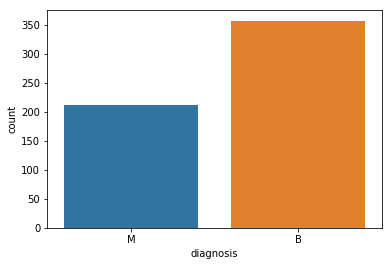

In [0]:
ax = sns.countplot(y,label="Count")       # M = 212, B = 357
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

## Stacking

### Random Search

In [0]:
clf1 = KNeighborsClassifier()
clf2 = DecisionTreeClassifier(random_state=0)
clf3 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs')
sclf = StackingClassifier(classifiers=[clf1,clf1, clf2, clf3], 
                          meta_classifier=meta_clf)



param_dist = {'kneighborsclassifier-1__n_neighbors': sp_randint(4, 30),
              'kneighborsclassifier-2__n_neighbors': sp_randint(4, 30),
          'decisiontreeclassifier__max_depth': sp_randint(2, 8),
          'meta-logisticregression__C':[0.01,0.1,1,2] }


candidates = 8

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, n_jobs=-1, verbose=5)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates parameter settings.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  80 | elapsed:    0.6s remaining:    0.4s


RandomizedSearchCV took 1.02 seconds for 8 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.954 (std: 0.035)
Parameters: {'decisiontreeclassifier__max_depth': 5, 'kneighborsclassifier-1__n_neighbors': 21, 'kneighborsclassifier-2__n_neighbors': 21, 'meta-logisticregression__C': 0.1}

Model with rank: 1
Mean validation score: 0.954 (std: 0.035)
Parameters: {'decisiontreeclassifier__max_depth': 5, 'kneighborsclassifier-1__n_neighbors': 21, 'kneighborsclassifier-2__n_neighbors': 12, 'meta-logisticregression__C': 0.1}

Model with rank: 3
Mean validation score: 0.953 (std: 0.035)
Parameters: {'decisiontreeclassifier__max_depth': 5, 'kneighborsclassifier-1__n_neighbors': 12, 'kneighborsclassifier-2__n_neighbors': 17, 'meta-logisticregression__C': 0.1}



[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.9s finished
E:\Anaconda3\envs\Ai\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Grid Search

In [0]:
clf1 = KNeighborsClassifier()
clf2 = DecisionTreeClassifier(random_state=0)
clf3 = GaussianNB()
lr = LogisticRegression(solver = 'lbfgs')
sclf = StackingClassifier(classifiers=[clf1,clf1, clf2, clf3], 
                          meta_classifier=lr)


param_grid = {'kneighborsclassifier-1__n_neighbors': [19,20,21,22,23],
              'kneighborsclassifier-2__n_neighbors': [19,20,21,22,23],
          'decisiontreeclassifier__max_depth': [3,4,5],
          'meta-logisticregression__C':[0.95,0.1,1.05] }


grid_search = GridSearchCV(sclf, param_grid , cv = 10, n_jobs=-1, verbose=5)

start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   20.2s


GridSearchCV took 27.22 seconds.
Model with rank: 1
Mean validation score: 0.954 (std: 0.035)
Parameters: {'decisiontreeclassifier__max_depth': 5, 'kneighborsclassifier-1__n_neighbors': 19, 'kneighborsclassifier-2__n_neighbors': 19, 'meta-logisticregression__C': 0.1}

Model with rank: 1
Mean validation score: 0.954 (std: 0.035)
Parameters: {'decisiontreeclassifier__max_depth': 5, 'kneighborsclassifier-1__n_neighbors': 19, 'kneighborsclassifier-2__n_neighbors': 20, 'meta-logisticregression__C': 0.1}

Model with rank: 1
Mean validation score: 0.954 (std: 0.035)
Parameters: {'decisiontreeclassifier__max_depth': 5, 'kneighborsclassifier-1__n_neighbors': 19, 'kneighborsclassifier-2__n_neighbors': 21, 'meta-logisticregression__C': 0.1}

Model with rank: 1
Mean validation score: 0.954 (std: 0.035)
Parameters: {'decisiontreeclassifier__max_depth': 5, 'kneighborsclassifier-1__n_neighbors': 19, 'kneighborsclassifier-2__n_neighbors': 22, 'meta-logisticregression__C': 0.1}

Model with rank: 1
Mean

[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:   27.1s finished
E:\Anaconda3\envs\Ai\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## XGBoosting

In [0]:
# Create classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5,4,size = 5),
          'subsample': np.random.uniform(0,1,size =4),
          'colsample_bytree': np.random.uniform(0,1,size =4),
          'max_depth': sp_randint(1, 7)}


candidates = 10

random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5)
start = time.time()
random_search.fit(X, y)
print('RandomizedSearchCV took {:.2f} seconds\
      for {} candidates parameter settings.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished
E:\Anaconda3\envs\Ai\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV took 9.29 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.968 (std: 0.027)
Parameters: {'colsample_bytree': 0.73276749239863, 'gamma': 2.306580849401802, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.9031777222608673}

Model with rank: 2
Mean validation score: 0.967 (std: 0.025)
Parameters: {'colsample_bytree': 0.5578699009183914, 'gamma': 2.4522953112782644, 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.42866347233907953}

Model with rank: 3
Mean validation score: 0.965 (std: 0.032)
Parameters: {'colsample_bytree': 0.5578699009183914, 'gamma': 2.306580849401802, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.42866347233907953}



### Grid Search

In [0]:
params = {'min_child_weight': [7,8,9],
          'gamma': [2.3,2.4,2.5],
          'subsample': [0.84,0.88, 0.92],
          'colsample_bytree': [0.66,0.71,0.74],
          'max_depth': [4, 5, 6]}

grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5)

start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  3.1min finished
E:\Anaconda3\envs\Ai\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False 

GridSearchCV took 184.66 seconds.
Model with rank: 1
Mean validation score: 0.972 (std: 0.024)
Parameters: {'colsample_bytree': 0.66, 'gamma': 2.3, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.88}

Model with rank: 1
Mean validation score: 0.972 (std: 0.024)
Parameters: {'colsample_bytree': 0.66, 'gamma': 2.3, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.88}

Model with rank: 1
Mean validation score: 0.972 (std: 0.024)
Parameters: {'colsample_bytree': 0.66, 'gamma': 2.3, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.88}

Model with rank: 1
Mean validation score: 0.972 (std: 0.021)
Parameters: {'colsample_bytree': 0.66, 'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.88}

Model with rank: 1
Mean validation score: 0.972 (std: 0.021)
Parameters: {'colsample_bytree': 0.66, 'gamma': 2.4, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.88}

Model with rank: 1
Mean validation score: 0.972 (std: 0.021)
Parameters: {'colsample_bytree': 0.66, '

# Results
TODO Statistical tests

# Conclusion

TODO